In [1]:
import os
import re
import sys
import glob
from pylab import cm
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
import warnings
warnings.simplefilter(action='ignore')
plt.rcParams['axes.linewidth'] = 3

In [2]:
# Obseravtory site details

OBS_NAME = 'Indian Astronomical Observatory'
OBS_LOCATION = 'Hanle'
OBS_LAT = '32:46:46'
OBS_LON = '78:57:51'
OBS_ALT = 4500
OBS_TIMEZONE = +5.5

# New CCD Specification

read_noise_new = 5.75
ccd_gain_new = 0.28
data_max_new = 700000

# Old CCD Specification

read_noise_old = 4.87
ccd_gain_old = 1.22
data_max_old = 55000

#------------------------------------------------#

# Specification of the object under study

OBJECT_NAME = 'SN 2020sck'
OBJECT_RA = '01:10:34.841'
OBJECT_DEC = '+02:06:50.15'
TYPE = 'Iax'
REDSHIFT = 0.017
EB_V = 0.0256
DM = 34.24
DM_err = 0.22

epoch = 2400000.5
B_band_maximum =  2459098.84

#------------------------------------------------#

RA_key = 'RA'
DEC_key = 'DEC'
UT_key = 'UT'
DATE_key = 'DATE-OBS'
FILTER_key = 'FILTER'
AIRMASS_key = 'AIRMASS'
EXPTIME_key = 'EXPTIME'
JD_keyword = 'JD'

epoch = 2400000.5
B_band_maximum =  2458066.3


#------------------------------------------------#
Spec_dir = "/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/"
save_results = '/home/anirban/2020sck/Results/New_Results/Results/Plots/'
spec_compare = "/home/anirban/2020sck_Reduced/Spec_Comparison/"
#------------------------------------------------#

In [3]:

# Functions for File handling

def remove_file(file_name):
    """
    Removes the file 'file_name' in the constituent directory.
    Args:
         file_name  : Name of the file to be removed from the current directory
    Returns:
        None
    """
    try:
        os.remove(file_name)
    except OSError:
        pass


def remove_similar_files(common_text):
    """
    Removes similar files based on the string 'common_text'.
    Args:
        common_text : String containing partial name of the files to be deleted
    Returns:
        None
    """
    for residual_file in glob.glob(common_text):
        remove_file(residual_file)


def group_similar_files(text_list, common_text, exceptions=''):
    """
    Groups similar files based on the string 'common_text'. Writes the similar files
    onto the list 'text_list' (only if this string is not empty) and appends the similar
    files to a list 'python_list'.
    Args:
        text_list   : Name of the output text file with names grouped based on the 'common_text'
        common_text : String containing partial name of the files to be grouped
        exceptions  : String containing the partial name of the files that need to be excluded
    Returns:
        list_files  : Python list containing the names of the grouped files
    """
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exception = exceptions.split(',')
        for file_name in glob.glob(common_text):
            for text in list_exception:
                test = re.search(text, file_name)
                if test:
                    try:
                        list_files.remove(file_name)
                    except ValueError:
                        pass

    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name + '\n')

    return list_files


def text_list_to_python_list(text_list):
    """
    Returns data in the file 'text_list' as a python_list.
    Args:
        text_list   : Input file containing filenames
    Returns:
        python_list : List of all the elements in the file 'text_list'
    Raises:
        Error : File 'text_list 'Not Found
    """
    if os.path.isfile(text_list):
        with open(text_list, 'r+') as f:
            python_list = f.read().split()
            return python_list
    else:
        print ("Error : File '{0}' Not Found".format(text_list))
        sys.exit(1)


def python_list_to_text_list(python_list, text_list):
    """
    Put the data from the input 'python_list' to a file 'text_list' line-wise.
    Args:
        python_list : Python_list from which data has to be read
        text_list   : Name of the text file onto which data has to be appended
    Returns:
        None
    """
    with open(text_list, 'w') as f:
        for element in python_list:
            f.write(element + '\n')            

In [4]:
def smooth_1dspec(file_name, sp = 3, kernel = 'gaussian', prefix_str = 'z_', plot = False):
    
    """
    Smoothens a 1-D spectra based on the smoothening parameter. Smoothening parameter
    is 'std.dev.' in case of isotropic Gaussian filter and is 'width' in the case of the
    non-isotropic box filter.
    Args:
        common_text : Common text of 1-D spectra files which have to be smoothened
        sp          : Smoothening parameter
        kernel      : Convolution Kernel used for smoothening (Gaussian or Box)
        prefix_str  : Prefix to distinguish the smoothened 1-D spectra from the original
        plot        : Boolean describing whether the smoothened spectra has to be plotted
    Returns:
        None
    """
    #for text in ['z_*.dat']:
    #    remove_similar_files(text)
    
    #list_spectra = group_similar_files('', common_text = common_text)
    usable_kernel = Gaussian1DKernel(int(sp), mode='oversample')
    
    if kernel.lower() != 'gaussian':
        if kernel.lower == 'box':
            usable_kernel = Box1DKernel(int(sp))
        else:
            print ("Error: Kernel '{0}' Not Recognised".format(kernel))
            sys.exit(1)
            
    #for file_name in list_spectra:
        #wave_data, flux_data = read_1dspec(file_name)
        #smoothed_data = convolve(flux_data, usable_kernel)
        #write_1dspec(ref_filename = file_name, flux_array = smoothed_data, prefix_str = prefix_str)
    read_df = pd.read_csv(file_name, sep='\s+', engine='python')
    if read_df.shape[1] == 2:
        colnames = ['Wave', 'Flux']
        unsmoothed_df = pd.read_csv(file_name, sep='\s+', names=colnames, engine='python')
    elif read_df.shape[1] == 3:
        colnames = ['Wave', 'Flux', 'FluxErr']
        unsmoothed_df = pd.read_csv(file_name, sep='\s+', names=colnames, engine='python')
    
    
    smoothed_flux = convolve(unsmoothed_df['Flux'].values, usable_kernel)
    wave_array = unsmoothed_df['Wave'].values
    unsmoothed_flux = unsmoothed_df['Flux'].values
    smoothed_df = pd.DataFrame(list(zip(wave_array, smoothed_flux)), columns=['Wavelength', 'Flux'])
    smoothed_flux = smoothed_df['Flux'].values
    #smoothed_df.to_csv(prefix_str+file_name, sep=' ', index=None, header=['Wavelength', 'Flux'])
        
    if plot:
        plt.figure(figsize=(6,6))
        plt.plot(wave_array, unsmoothed_flux, 'g', label = 'Original Spectrum')
        plt.plot(wave_array, smoothed_flux, 'r--', label = 'Smooth Spectrum', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()
        
    return smoothed_df

def plot_comp(smooth_df, redshift, clip_str = '3500:9200', apply_red = False,
             apply_dered=False):
    
    lower_clip, upper_clip = clip_str.split(':')
    
    #df_read = pd.read_csv(filename, sep = '\s+', engine = 'python', comment = '#')
    #if df_read.shape[1] == 2:
    #    colnames = ['Wave', 'Flux']
    #    df = pd.read_csv(filename, sep = '\s+', engine = 'python', names = colnames, comment = '#')
    #    df = df[(df['Wave'] >= int(lower_clip)) & (df['Wave'] <= int(upper_clip))]
    #elif df_read.shape[1] == 3:
    #    colnames = ['Wave', 'Flux', 'FluxErr']
    #    df = pd.read_csv(filename, sep = '\s+', engine = 'python', names = colnames, comment = '#')
    
    smooth_df = smooth_df[(smooth_df['Wavelength'] >= int(lower_clip)) & (smooth_df['Wavelength'] <= int(upper_clip))]
    smooth_df['LogFlux'] = smooth_df['Flux'].apply(lambda x: np.log10(x))

    if apply_red:
        smooth_df['Wavelength'] = smooth_df['Wavelength'].apply(lambda x: (x/(1+redshift)))
    if apply_dered:
        smooth_df['Wavelength'] = smooth_df['Wavelength'].apply(lambda x: (x*(1+redshift)))
    
    return smooth_df

In [5]:
spectra_sck_list = sorted(glob.glob(Spec_dir+'z_drgts*.dat'))

In [6]:
spectra_sck_list

['/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-08-31_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-01_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-02_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-07_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-08_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-11_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-13_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-16_SN2020sck.dat',
 '/home/anirban/2020sck_Reduced/Spectroscopy_20210721/galaxy_lines_removed/z_drgts2020-09-20-SN2020sck.dat',
 '/home/anirban/202

In [7]:
spectra_sck_early =  pd.read_csv(spectra_sck_list[0], sep = '\s+', dtype='float64')
spectra_sck_early = spectra_sck_early[(spectra_sck_early['Wavelength'] >= int(3500)) & \
                                      (spectra_sck_early['Wavelength'] <= int(8970))]
spectra_sck_early['LogFlux'] = spectra_sck_early['Flux'].apply(lambda x: np.log10(x))

#=============================================================================================#

spectra_sck_max = pd.read_csv(spectra_sck_list[3], sep='\s+', dtype='float64')
spectra_sck_max = spectra_sck_max[(spectra_sck_max['Wavelength'] >= int(3600)) & \
                                      (spectra_sck_max['Wavelength'] <= int(9000))]
spectra_sck_max['LogFlux'] = spectra_sck_max['Flux'].apply(lambda x: np.log10(x))

#=============================================================================================#

spectra_sck_late = pd.read_csv(spectra_sck_list[-1], sep='\s+', dtype='float64')
spectra_sck_late = spectra_sck_late[(spectra_sck_late['Wavelength'] >= int(4000)) & \
                                   (spectra_sck_late['Wavelength'] <= int(9000))]
spectra_sck_late['LogFlux'] = spectra_sck_late['Flux'].apply(lambda x: np.log10(x))


#=============================================================================================#

spectra_sck_postmax = pd.read_csv(spectra_sck_list[7], sep='\s+', dtype='float64')
spectra_sck_postmax = spectra_sck_postmax[(spectra_sck_postmax['Wavelength'] >= int(3600)) & \
                                          (spectra_sck_postmax['Wavelength'] <= int(9000))]
spectra_sck_postmax['LogFlux'] = spectra_sck_postmax['Flux'].apply(lambda x: np.log10(x))

In [8]:
early_folder = spec_compare + 'Early/'
max_folder = spec_compare + 'Max/'
late_folder = spec_compare + 'Late/'
post_max_foler = spec_compare + 'Post-Max/'

In [23]:
smooth_df_cx = smooth_1dspec(early_folder + '2002cx-4.5.dat', plot=False)
smooth_df_hk = smooth_1dspec(early_folder + '2005hk-5.2.dat', plot=False)
smooth_df_z = smooth_1dspec(early_folder + '2012Z-5.0.dat', plot=False)
smooth_df_ek = smooth_1dspec(early_folder + '2014ek-5.1.dat', plot=False)
smooth_df_ck = smooth_1dspec(early_folder + '2014ck-4.0.dat', plot=False)
smooth_df_muj = smooth_1dspec(early_folder + '2019muj-5.0.dat', plot=False)
#print (smooth_df_cx.columns)

In [10]:
smooth_df_hk_max = smooth_1dspec(max_folder + '2005hk+2.7.dat', plot=False)
smooth_df_ae_max = smooth_1dspec(max_folder + '2010ae+1.9.dat', plot=False)
smooth_df_z_max = smooth_1dspec(max_folder + '2012Z+1.8.dat', plot=False)
smooth_df_muj_max = smooth_1dspec(max_folder + '2019muj+1.0.dat', plot=False)

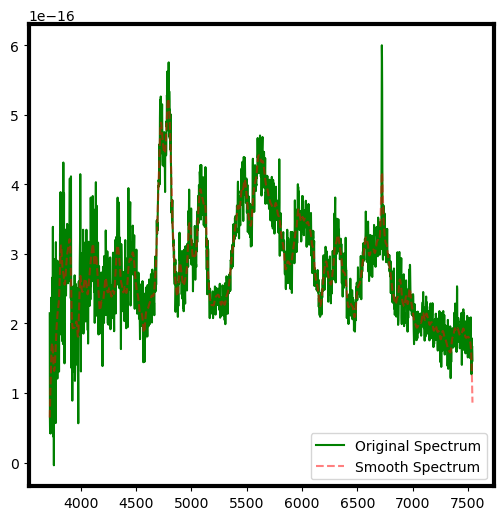

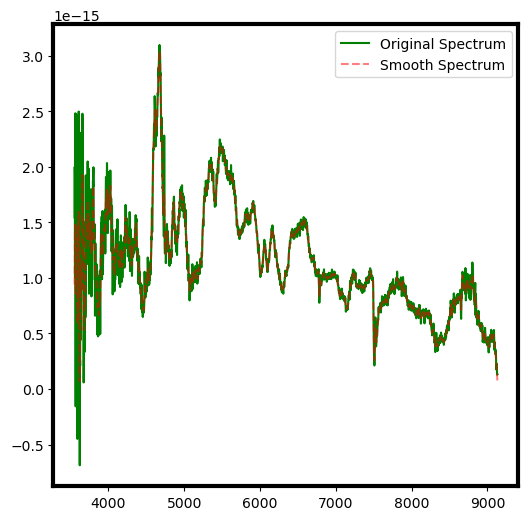

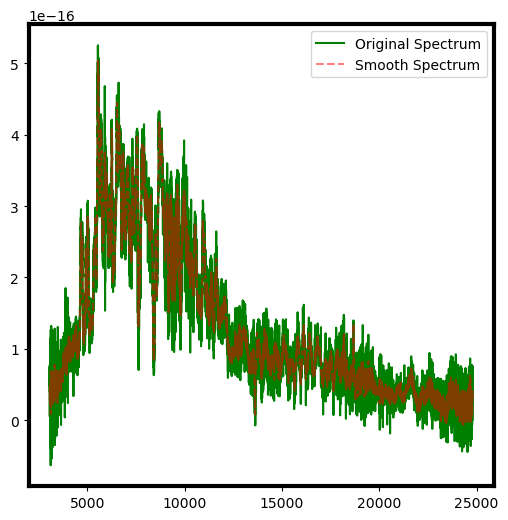

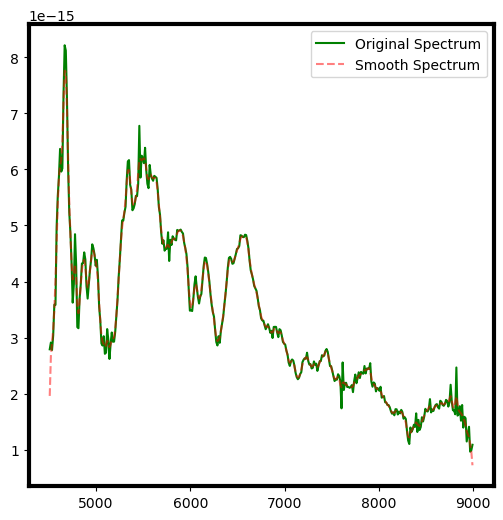

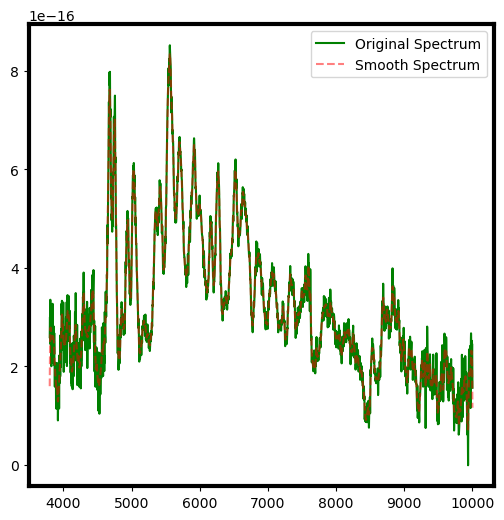

In [11]:
smooth_df_cx_post = smooth_1dspec(post_max_foler + '2002cx+11.5.dat', sp=5, plot=True)
smooth_df_hk_post = smooth_1dspec(post_max_foler + '2005hk+9.9.asc', plot=True)
smooth_df_ae_post = smooth_1dspec(post_max_foler + '2010ae+10.9.dat', sp=5, plot=True)
smooth_df_z_post = smooth_1dspec(post_max_foler + '2012Z+10.1.dat', sp=1.5, plot=True)
smooth_df_muj_post = smooth_1dspec(post_max_foler + '2019muj+11.0.dat', plot=True)

In [12]:
smooth_df_hk_late = smooth_1dspec(late_folder + '2005hk+67.dat', plot=False)
smooth_df_ha_late = smooth_1dspec(late_folder + 'SN2008ha+68.dat', sp=5, plot=False)
smooth_df_z_late = smooth_1dspec(late_folder + '2012Z+194.dat', sp=10, plot=False)

In [24]:
clip_str = '3500:9200'

#fig, ax = plt.subplots(1, 1, figsize=(10,10))

df_cx = plot_comp(smooth_df=smooth_df_cx, redshift=0.024, 
                  clip_str='3500:6800', apply_red=True)

df_hk = plot_comp(smooth_df=smooth_df_hk, redshift=0.012936,
                 clip_str='3500:9000', apply_red=False)

df_z = plot_comp(smooth_df=smooth_df_z, redshift=0.0071,
                clip_str='3500:7200', apply_red=True)

df_ek = plot_comp(smooth_df=smooth_df_ek, redshift=0.023, 
                  clip_str='3500:8600', apply_red=True)

df_ck = plot_comp(smooth_df=smooth_df_ck, redshift=0.005, clip_str='3800:8500',
                 apply_red=True)


df_muj = plot_comp(smooth_df=smooth_df_muj, redshift=0.007, apply_red=True)

#df_sck = plot_comp(filename=Spec_dir + 'drts2020-08-31_2020sck.dat', phase='-5.5', name='2020sck',
#                  redshift=0.016)

In [27]:
df_hk_max = plot_comp(smooth_df=smooth_df_hk_max, redshift=0.0129, 
                      clip_str='3500:9000', apply_red=False)
df_ae_max = plot_comp(smooth_df=smooth_df_ae_max, redshift=0.003662,
                     clip_str='3500:9000', apply_red=True)
df_z_max = plot_comp(smooth_df=smooth_df_z_max, redshift=0.0071,
                    clip_str='3900:8800', apply_red=True)
df_muj_max = plot_comp(smooth_df=smooth_df_muj_max, redshift=0.007,
                      clip_str='3500:9000', apply_red=True)

In [28]:
df_cx_post = plot_comp(smooth_df=smooth_df_cx_post, redshift=0.024,
                      clip_str='3500:7300', apply_red=True)
df_hk_post = plot_comp(smooth_df=smooth_df_hk_post, redshift=0.0129,
                      clip_str='3800:9000', apply_red=False)
df_ae_post = plot_comp(smooth_df=smooth_df_ae_post, redshift=0.00366,
                     clip_str='3500:9000', apply_red=True)
df_z_post = plot_comp(smooth_df=smooth_df_z_post, redshift=0.0071,
                     clip_str='3800:9000', apply_red=True)
df_muj_post = plot_comp(smooth_df_muj_post, redshift=0.007,
                       clip_str='3500:9000', apply_red=True)

In [29]:
df_hk_late = plot_comp(smooth_df=smooth_df_hk_late, redshift=0.01293,
                      clip_str='3500:9000', apply_red=True)
df_ha_late = plot_comp(smooth_df=smooth_df_ha_late, redshift=0.0046,
                      clip_str='4000:8800', apply_red=True)
df_z_late = plot_comp(smooth_df=smooth_df_z_late, redshift=0.0071,
                     clip_str='4200:9000', apply_red=True)

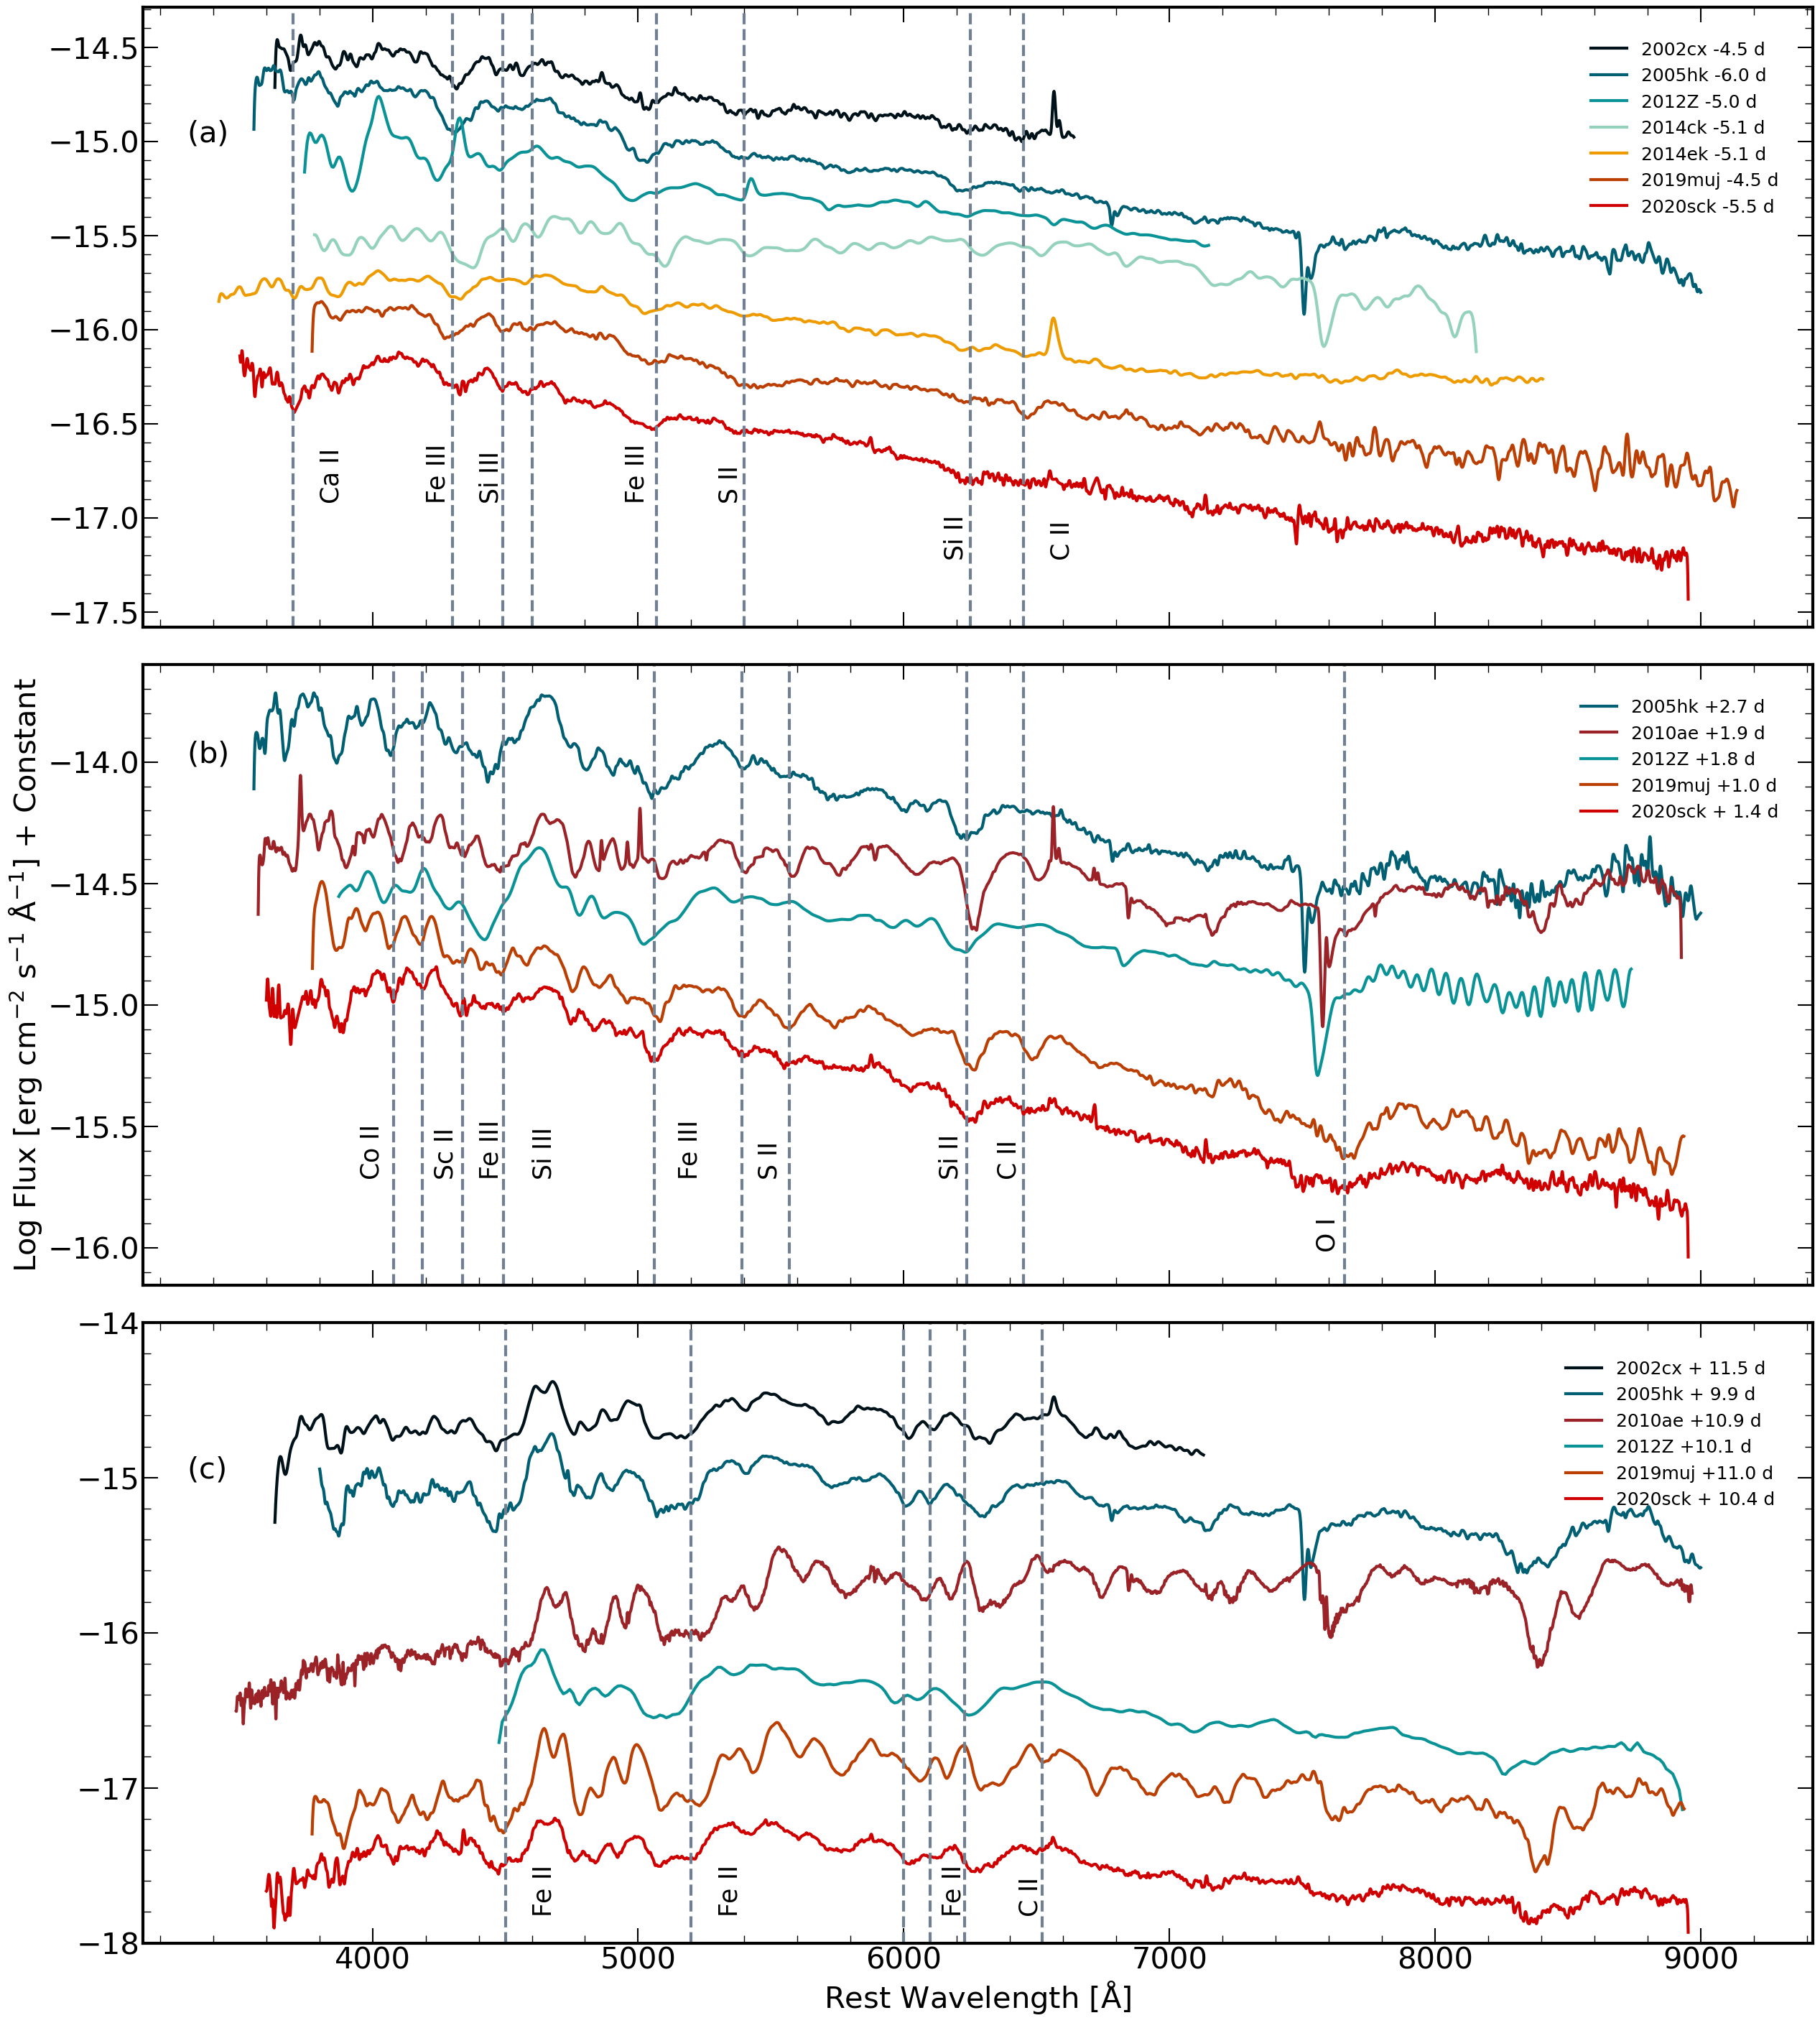

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(30, 35), facecolor='white', sharex=True)
plt.subplots_adjust(wspace=0.05, hspace=0.06)

#legend_properties = {'weight': 'bold', 'size': 20}
#fig, ax = plt.subplots(1, 1, figsize=(15, 15))
#plt.rcParams['axes.linewidth'] = 3
ax[0].plot(df_cx['Wavelength'], df_cx['LogFlux']+0.7, color='#001219',
          lw=3.0, label='2002cx' + ' '+ str(-4.5) + ' ' +'d')

ax[0].plot(df_hk['Wavelength'], df_hk['LogFlux']-0.16, color='#005f73',
          lw=3.0, label='2005hk' + ' '+ str(-6.0) + ' ' +'d')


ax[0].plot(df_z['Wavelength'], df_z['LogFlux']-0.22, color='#0a9396',
          lw=3.0, label='2012Z' + ' '+ str(-5.0) + ' ' +'d')


ax[0].plot(df_ck['Wavelength'], df_ck['LogFlux']+0.1, color='#94d2bd',
          lw=3.0, label='2014ck' + ' '+ str(-5.1) + ' ' + 'd')



ax[0].plot(df_ek['Wavelength'], df_ek['LogFlux']-0.3, color='#ee9b00',
          lw=3.0, label='2014ek' + ' '+ str(-5.1) + ' ' + 'd')


ax[0].plot(df_muj['Wavelength'], df_muj['LogFlux']-0.9, color='#bb3e03',
          lw=3.0, label='2019muj' + ' '+ str(-4.5) + ' ' +'d')



ax[0].plot(spectra_sck_early['Wavelength'], spectra_sck_early['LogFlux']-1.4, color='#d00000',
          lw=3.0, label='2020sck' + ' '+str(-5.5)+ ' ' + 'd')


draw_line = [3700, 4300, 4490, 4600, 5070, 5400, 6250, 6450]

for lines in draw_line:
    ax[0].axvline(lines, ls='--', lw=3.0, color='slategray')


dict_label = {1 : [r'$\rm Ca\ II\ $', 3800, -16.9],
              2: [r'$\rm Fe\ III\ $', 4200, -16.9],
              3: [r'$\rm Si\ III\ $', 4400, -16.9],
              4: [r'$\rm Fe\ III\ $', 4950, -16.9],
              5: [r'$\rm S\ II\ $', 5300, -16.9],
              6: [r'$\rm Si\ II\ $', 6150, -17.2], 
              7: [r'$\rm C\ II\ $', 6550, -17.2]}
              #8: [r'$\rm --O\ I\ 7774$', 7600, -2.1e39],
             # 9: [r'$\rm --Ca\ II\ $', 8400, -1.9e39]
for (number, [line, wavelength, pos]) in dict_label.items():
    ax[0].text(wavelength, pos, line, fontsize = 25, rotation = 'vertical')        

#ax.text(x = 7500, y = df_sck['LogFlux'].values[-1]-1.3, 
#        s = '2020sck' + ' '+ str(-4.5)+'d', fontsize = 25)

ax[0].xaxis.set_ticks_position('both')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_major_locator(MultipleLocator(1000))
ax[0].xaxis.set_minor_locator(MultipleLocator(200))
ax[0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].tick_params(axis='y', which='major', direction='in', length = 15, width=1.5)
ax[0].tick_params(axis='y', which='minor', direction='in', length = 8, width=1.0)
ax[0].tick_params(axis='x', which='major', direction='in', length = 15, width=1.5)
ax[0].tick_params(axis='x', which='minor', direction='in', length = 8, width=1.0)
              

#ax.yaxis.set_major_formatter(plt.NullFormatter()) 
for tick in ax[0].xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    
for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    
ax[0].legend(loc='upper right', fancybox=False, shadow=False, fontsize = 18,
             markerscale=1.5, borderaxespad=1.5, frameon=False)    
    
ax[0].text(3300, -15, r'$\rm (a)$', fontsize=30)    
    
#=============================================================================================#


ax[1].plot(df_hk_max['Wavelength'], df_hk_max['LogFlux']+0.7, color='#005f73',
          lw=3.0, label='2005hk +' + str(2.7) + ' ' + 'd')

ax[1].plot(df_ae_max['Wavelength'], df_ae_max['LogFlux']+0.9, color='#9b2226',
          lw=3.0, label='2010ae +' + str(1.9) + ' '+ 'd')


ax[1].plot(df_z_max['Wavelength'], df_z_max['LogFlux']-0.4, color='#0a9396',
          lw=3.0, label='2012Z +' + str(1.8) + ' '+ 'd')


ax[1].plot(df_muj_max['Wavelength'], df_muj_max['LogFlux'], color='#bb3e03',
          lw=3.0, label='2019muj +' + str(1.0) + ' '+ 'd')

ax[1].plot(spectra_sck_max['Wavelength'], spectra_sck_max['LogFlux']-0.2, color='#d00000',
          lw=3.0, label='2020sck +' + ' '+str(1.4)+ ' ' + 'd')

draw_line = [4079, 4189, 4338, 4493, 5060, 5391, 5568, 6238, 6450, 7660]

for lines in draw_line:
    ax[1].axvline(lines, ls='--', lw=3.0, color='slategray')
    
dict_label = {1 : [r'$\rm Co\ II\ $', 3950, -15.7],
              2: [r'$\rm Sc\ II\ $', 4230, -15.7],
              3: [r'$\rm Fe\ III\ $', 4400, -15.7],
              4: [r'$\rm Si\ III\ $', 4600, -15.7],
              5: [r'$\rm Fe\ III\ $', 5150, -15.7],
              6: [r'$\rm S\ II\ $',  5450, -15.7],
              7: [r'$\rm Si\ II\ $', 6130, -15.7],
              8: [r'$\rm C\ II\ $', 6350, -15.7],
              9: [r'$\rm O\ I\ $', 7550, -16.0]}
for (number, [line, wavelength, pos]) in dict_label.items():
    ax[1].text(wavelength, pos, line, fontsize = 25, rotation = 'vertical')       

ax[1].xaxis.set_ticks_position('both')
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_major_locator(MultipleLocator(1000))
ax[1].xaxis.set_minor_locator(MultipleLocator(200))
ax[1].yaxis.set_major_locator(MultipleLocator(0.5))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1].tick_params(axis='y', which='major', direction='in', length = 15, width=1.5)
ax[1].tick_params(axis='y', which='minor', direction='in', length = 8, width=1.0)
ax[1].tick_params(axis='x', which='major', direction='in', length = 15, width=1.5)
ax[1].tick_params(axis='x', which='minor', direction='in', length = 8, width=1.0)
              

#ax.yaxis.set_major_formatter(plt.NullFormatter()) 
for tick in ax[1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    
for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    
ax[1].legend(loc='upper right', fancybox=False, shadow=False, fontsize = 18,
             markerscale=1.5, borderaxespad=1.5, frameon=False)    

ax[1].text(3300, -14, r'$\rm (b)$', fontsize=30) 
#=============================================================================================#

ax[2].plot(df_cx_post['Wavelength'], df_cx_post['LogFlux']+0.9, color='#001219',
          lw=3.0, label='2002cx +' + ' '+ str(11.5) + ' ' +'d')    

ax[2].plot(df_hk_post['Wavelength'], df_hk_post['LogFlux']-0.20, color='#005f73',
          lw=3.0, label='2005hk +' + ' '+ str(9.9) + ' ' +'d')

ax[2].plot(df_ae_post['Wavelength'], df_ae_post['LogFlux']-0.15, color='#9b2226',
          lw=3.0, label='2010ae +' + str(10.9) + ' '+ 'd')

ax[2].plot(df_z_post['Wavelength'], df_z_post['LogFlux']-2.0, color='#0a9396',
          lw=3.0, label='2012Z +' + str(10.1) + ' '+ 'd')

ax[2].plot(df_muj_post['Wavelength'], df_muj_post['LogFlux']-1.5, color='#bb3e03',
          lw=3.0, label='2019muj +' + str(11.0) + ' '+ 'd')

ax[2].plot(spectra_sck_postmax['Wavelength'], spectra_sck_postmax['LogFlux'] - 2.2, color='#d00000',
          lw=3.0, label='2020sck +' + ' '+str(10.4)+ ' ' + 'd')

draw_line = [4500, 5200, 6000, 6100, 6230, 6520]

for lines in draw_line:
    ax[2].axvline(lines, ls='--', lw=3.0, color='slategray')
    
    
dict_label = {1 : [r'$\rm Fe\ II\ $', 4600, -17.8],
              2: [r'$\rm Fe\ II\ $', 5300, -17.8],
              3: [r'$\rm Fe\ II\ $', 6140, -17.8],
              4: [r'$\rm C\ II\ $', 6430, -17.8]}
              #5: [r'$\rm Fe\ III\ $', 5150, -15.7],
              #6: [r'$\rm S\ II\ $',  5450, -15.7],
              #7: [r'$\rm Si\ II\ $', 6130, -15.7],
              #8: [r'$\rm C\ II\ $', 6350, -15.7],
              #9: [r'$\rm O\ I\ $', 7550, -16.0]
for (number, [line, wavelength, pos]) in dict_label.items():
    ax[2].text(wavelength, pos, line, fontsize = 25, rotation = 'vertical')       
    
ax[2].text(3300, -15, r'$\rm (c)$', fontsize=30) 
#=============================================================================================#


#ax[2].plot(df_hk_late['Wavelength'], df_hk_late['LogFlux'] + 0.7, color='#005f73',
#          lw=3.0, label='2005hk +' + str(67) + ' ' + 'd') # 0.7

#ax[2].plot(df_ha_late['Wavelength'], df_ha_late['LogFlux'] + 0.5, color='#ae2012',
#          lw=3.0, label='2008ha +' + str(68) + ' '+ 'd')  # 0.9


#ax[2].plot(df_z_late['Wavelength'], df_z_late['LogFlux'] - 0.8, color='#0a9396',
#          lw=3.0, label='2012Z +' + str(194) + ' '+ 'd')   #-0.4

#ax[2].plot(spectra_sck_late['Wavelength'], spectra_sck_late['LogFlux'] - 2.0, color='#d00000',
#          lw=3.0, label='2020sck +' + ' '+str(127.0)+ ' ' + 'd')   #-1.4

#=============================================================================================#


#draw_bands = [7260, 8450]

#ax[2].axvspan(7270, 7310, color='slategray', alpha=0.5)
#ax[2].axvspan(8500, 8650, color='slategray', alpha=0.5)
#ax[2].axvspan(5800, 5850, color='slategray', alpha=0.3)

ax[2].xaxis.set_ticks_position('both')
ax[2].yaxis.set_ticks_position('both')
ax[2].xaxis.set_major_locator(MultipleLocator(1000))
ax[2].xaxis.set_minor_locator(MultipleLocator(200))
ax[2].yaxis.set_major_locator(MultipleLocator(1.0))
ax[2].yaxis.set_minor_locator(MultipleLocator(0.2))
ax[2].tick_params(axis='y', which='major', direction='in', length = 15, width=1.5)
ax[2].tick_params(axis='y', which='minor', direction='in', length = 8, width=1.0)
ax[2].tick_params(axis='x', which='major', direction='in', length = 15, width=1.5)
ax[2].tick_params(axis='x', which='minor', direction='in', length = 8, width=1.0)
              

#ax.yaxis.set_major_formatter(plt.NullFormatter()) 
for tick in ax[2].xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    
for tick in ax[2].yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    
ax[2].legend(loc='upper right', fancybox=False, shadow=False, fontsize = 18,
             markerscale=1.0, borderaxespad=1.7, frameon=False, bbox_to_anchor=(1.0, 1.0))

ax[2].set_ylim(-18, -14)

ax[2].set_xlabel(r'Rest Wavelength [$\rm \AA$]', fontsize=30)
ax[1].set_ylabel(r'Log Flux [$\rm erg\ cm^{-2}\ s^{-1}\ \AA^{-1}$] + Constant', fontsize=30)
#ax[1].yaxis.set_label_coords(-0.05, 0);
plt.savefig(save_results+'Spec_compare.png', dpi=100, bbox_inches='tight', facecolor='white');
plt.show();


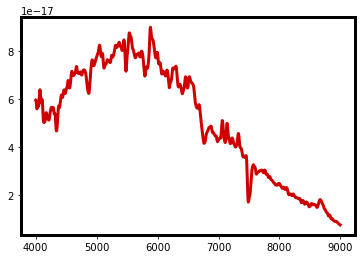

In [31]:
plt.plot(spectra_sck_late['Wavelength'], spectra_sck_late['Flux'], color='#d00000',
          lw=3.0, label='2020sck' + ' '+str(+127.0)+ ' ' + 'd')